# Employee Sentiment Analysis – Project

This notebook performs sentiment analysis on employee emails to:
- Label each message with sentiment (Positive / Negative / Neutral)
- Perform Exploratory Data Analysis (EDA)
- Compute monthly sentiment scores per employee
- Rank employees based on these scores
- Identify flight risk employees (4+ negative mails in 30 days)
- Build a linear regression model to analyze and predict sentiment trends

Dataset: `test.csv`


In [ ]:
# 1. Import all required libraries

import pandas as pd                # data manipulation
import numpy as np                 # numerical operations
import matplotlib.pyplot as plt    # plotting
import seaborn as sns              # prettier plots

from datetime import timedelta     # for 30-day windows

# Sentiment analysis (lexicon-based)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine learning (for regression model)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 2. Load and inspect the dataset


In [ ]:
# Download VADER lexicon the first time
nltk.download("vader_lexicon")

# Load the CSV file
df = pd.read_csv("test.csv")

# Look at first 5 rows
df.head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [ ]:
# Shape of the data (rows, columns)

print("Shape:", df.shape)



Shape: (2191, 4)


In [ ]:
# Column data types

print("\nData types:")
print(df.dtypes)


Data types:
Subject    object
body       object
date       object
from       object
dtype: object


In [ ]:
# Check missing values

print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
Subject    0
body       0
date       0
from       0
dtype: int64


## 3. Data Cleaning and Feature Engineering

Steps:
- Parse the `date` column into a proper datetime type.
- Combine `Subject` and `body` into a single text field.
- Create helper columns like `message_length` and `year_month`.


In [ ]:
# Make a copy to avoid modifying the original df directly

data = df.copy()

In [ ]:
# 1. Parse date column into datetime format

data["date"] = pd.to_datetime(data["date"], errors="coerce")
data

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com
...,...,...,...,...
2186,Re: Resume,Thanks for the resume. She has had some good ...,2011-06-17,johnny.palmer@enron.com
2187,"Final Schedule - Wednesday, May 2, 2001 - Jesu...",Attached please find the following documents:\...,2011-01-20,johnny.palmer@enron.com
2188,(No Subject),Good to finally hear from. Judging from your ...,2011-01-02,don.baughman@enron.com
2189,League is Set,It looks like we have our 12 teams. We will p...,2011-03-11,rhonda.denton@enron.com


In [ ]:
data.dtypes

,0
Subject,object
body,object
date,datetime64[ns]
from,object


In [ ]:
# 2. Drop rows where date could not be parsed

data = data.dropna(subset=["date"])
data

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com
...,...,...,...,...
2186,Re: Resume,Thanks for the resume. She has had some good ...,2011-06-17,johnny.palmer@enron.com
2187,"Final Schedule - Wednesday, May 2, 2001 - Jesu...",Attached please find the following documents:\...,2011-01-20,johnny.palmer@enron.com
2188,(No Subject),Good to finally hear from. Judging from your ...,2011-01-02,don.baughman@enron.com
2189,League is Set,It looks like we have our 12 teams. We will p...,2011-03-11,rhonda.denton@enron.com


In [ ]:
# 3. Fill missing Subject or body with empty string

# Remove subjects like "(No Subject)", "(no subject)", "(NO SUBJECT)" etc.
data["Subject"] = data["Subject"].str.replace(
    r'(?i)^\(no subject\)$',   # regex pattern
    '',                        # replace with empty string
    regex=True
)


# Replace actual missing values with empty string
data["Subject"] = data["Subject"].fillna("")
data["body"] = data["body"].fillna("")


In [ ]:
data['Subject']

,Subject
0,EnronOptions Update!
1,
2,Phone Screen Interview - Shannon L. Burnham
3,RE: My new work email
4,Bet
...,...
2186,Re: Resume
2187,"Final Schedule - Wednesday, May 2, 2001 - Jesu..."
2188,
2189,League is Set


In [ ]:
# 4. Create a combined text column: subject + body

data["text"] = (data["Subject"] + " " + data["body"]).str.strip()
data.head()

,Subject,body,date,from,text
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...
1,,"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,"Marc,\n\nUnfortunately, today is not going to ..."
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...


In [ ]:
data["Subject"].value_counts().head(10)


,count
Subject,
,144
Re:,76
RE:,17
Interview Schedule,9
Congratulations,9
Master Power Contracts,8
Re: Expense Reports,8
RE: TradersNews,7
Congratulations!,7


In [ ]:
# 5. Standardize sender column name (employee identifier)

data.rename(columns={"from": "employee"}, inplace=True)
data

,Subject,body,date,employee,text
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...
1,,"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,"Marc,\n\nUnfortunately, today is not going to ..."
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...
...,...,...,...,...,...
2186,Re: Resume,Thanks for the resume. She has had some good ...,2011-06-17,johnny.palmer@enron.com,Re: Resume Thanks for the resume. She has had...
2187,"Final Schedule - Wednesday, May 2, 2001 - Jesu...",Attached please find the following documents:\...,2011-01-20,johnny.palmer@enron.com,"Final Schedule - Wednesday, May 2, 2001 - Jesu..."
2188,,Good to finally hear from. Judging from your ...,2011-01-02,don.baughman@enron.com,Good to finally hear from. Judging from your ...
2189,League is Set,It looks like we have our 12 teams. We will p...,2011-03-11,rhonda.denton@enron.com,League is Set It looks like we have our 12 tea...


In [ ]:
# 6. Create helper columns

data["message_length_chars"] = data["text"].str.len()
data["message_length_words"] = data["text"].str.split().str.len()


In [ ]:
# 7. Create year-month column for monthly aggregation

data["year_month"] = data["date"].dt.to_period("M").astype(str)


In [ ]:
data.head()

,Subject,body,date,employee,text,message_length_chars,message_length_words,year_month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,713,103,2010-05
1,,"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,"Marc,\n\nUnfortunately, today is not going to ...",315,57,2010-07
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...,192,28,2011-07
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,176,29,2010-03
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,201,43,2011-05


## 4. Task 1 – Sentiment Labeling

We use NLTK's VADER sentiment analyzer:
- Compute a compound score in range [-1, 1]
- Map scores to labels:
  - compound >= 0.05 → Positive
  - compound <= -0.05 → Negative
  - otherwise → Neutral


In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment label from text
def get_sentiment_label(text):
    scores = sia.polarity_scores(str(text))
    compound = scores["compound"]

    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply function to each message
data["sentiment_label"] = data["text"].apply(get_sentiment_label)

# Also store the compound score as numeric sentiment score
data["sentiment_compound"] = data["text"].apply(
    lambda t: sia.polarity_scores(str(t))["compound"]
)

# Quick check
data[["Subject", "employee", "date", "sentiment_label", "sentiment_compound"]].head()


,Subject,employee,date,sentiment_label,sentiment_compound
0,EnronOptions Update!,sally.beck@enron.com,2010-05-10,Positive,0.8309
1,,eric.bass@enron.com,2010-07-29,Positive,0.4215
2,Phone Screen Interview - Shannon L. Burnham,sally.beck@enron.com,2011-07-25,Neutral,0.0000
3,RE: My new work email,johnny.palmer@enron.com,2010-03-25,Neutral,0.0000
4,Bet,lydia.delgado@enron.com,2011-05-21,Positive,0.2500


## 5. Task 2 – Exploratory Data Analysis (EDA)

We will:
- Look at basic structure and distributions
- Check sentiment label distribution
- Analyze trends over time
- Look at basic patterns per employee


In [ ]:
# Basic statistics for numeric columns

data.describe(include="all")


,Subject,body,date,employee,text,message_length_chars,message_length_words,year_month,sentiment_label,sentiment_compound
count,2191,2191,2191,2191,2191,2191.000000,2191.000000,2191,2191,2191.000000
unique,1250,1539,NaN,10,1563,NaN,NaN,24,3,NaN
top,,\n\n,NaN,lydia.delgado@enron.com,TradersNews: Confirmation Request when possibl...,NaN,NaN,2010-04,Positive,NaN
freq,144,21,NaN,284,6,NaN,NaN,92,1574,NaN
mean,NaN,NaN,2010-12-31 02:17:21.716111360,NaN,NaN,282.342309,45.112277,NaN,NaN,0.432382
min,NaN,NaN,2010-01-01 00:00:00,NaN,NaN,0.000000,0.000000,NaN,NaN,-0.959700
25%,NaN,NaN,2010-06-30 12:00:00,NaN,NaN,103.000000,17.000000,NaN,NaN,0.000000
50%,NaN,NaN,2011-01-01 00:00:00,NaN,NaN,198.000000,32.000000,NaN,NaN,0.493900
75%,NaN,NaN,2011-06-30 12:00:00,NaN,NaN,387.000000,61.000000,NaN,NaN,0.796400
max,NaN,NaN,2011-12-31 00:00:00,NaN,NaN,1060.000000,191.000000,NaN,NaN,0.994300


sentiment_label
Positive    1574
Neutral      454
Negative     163
Name: count, dtype: int64


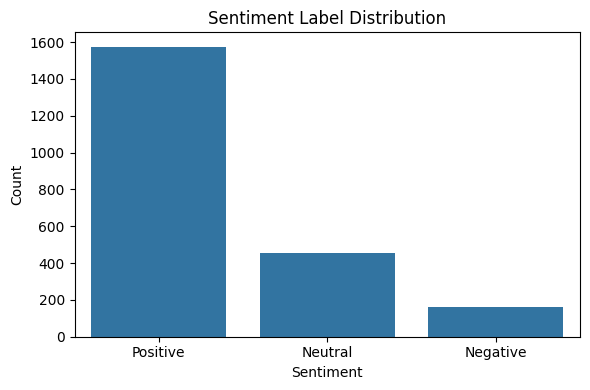

In [ ]:
# Count of each sentiment label
sentiment_counts = data["sentiment_label"].value_counts()

print(sentiment_counts)

# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment_label", data=data)
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


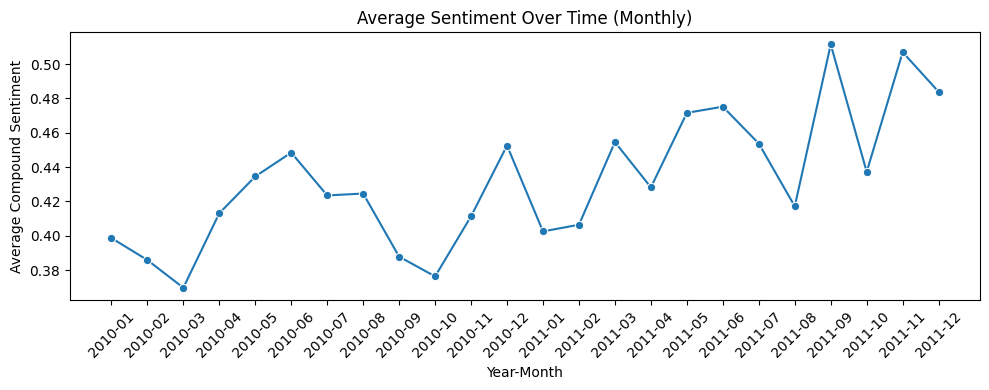

,year_month,sentiment_compound
0,2010-01,0.398702
1,2010-02,0.385873
2,2010-03,0.369744
3,2010-04,0.413110
4,2010-05,0.434527


In [ ]:
# Average compound sentiment per month
monthly_sentiment = (
    data.groupby("year_month")["sentiment_compound"]
        .mean()
        .reset_index()
        .sort_values("year_month")
)

plt.figure(figsize=(10, 4))
sns.lineplot(x="year_month", y="sentiment_compound", data=monthly_sentiment, marker="o")
plt.xticks(rotation=45)
plt.title("Average Sentiment Over Time (Monthly)")
plt.xlabel("Year-Month")
plt.ylabel("Average Compound Sentiment")
plt.tight_layout()
plt.show()

monthly_sentiment.head()


## 6. Task 3 – Employee Monthly Sentiment Score

We assign scores:
- Positive: +1
- Negative: -1
- Neutral: 0

Then we aggregate per employee and per month.


In [ ]:
# Map sentiment label to numeric score
label_to_score = {"Positive": 1, "Negative": -1, "Neutral": 0}
data["sentiment_score"] = data["sentiment_label"].map(label_to_score)

# Compute monthly score per employee
monthly_scores = (
    data.groupby(["employee", "year_month"])["sentiment_score"]
        .sum()
        .reset_index()
        .rename(columns={"sentiment_score": "monthly_sentiment_score"})
)

monthly_scores.head()


,employee,year_month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,3
4,bobette.riner@ipgdirect.com,2010-05,3


## 7. Task 4 – Employee Ranking

For each month:
- Top 3 Positive employees (highest monthly_sentiment_score)
- Top 3 Negative employees (lowest monthly_sentiment_score)

Tie-breaking:
- Sort by score (desc/asc) and then by employee name (alphabetical).


In [ ]:
def get_monthly_rankings(monthly_scores_df, month_str):
    """
    month_str example: '2010-05'
    Returns top 3 positive and top 3 negative employees for that month.
    """
    month_data = monthly_scores_df[monthly_scores_df["year_month"] == month_str]

    # Sort for positive: first by score desc, then employee name asc
    top_positive = (
        month_data.sort_values(
            by=["monthly_sentiment_score", "employee"],
            ascending=[False, True]
        )
        .head(3)
    )

    # Sort for negative: score asc (more negative first), then employee asc
    top_negative = (
        month_data.sort_values(
            by=["monthly_sentiment_score", "employee"],
            ascending=[True, True]
        )
        .head(3)
    )

    return top_positive, top_negative

# Example for one month (change '2010-05' to any month present in data)
example_month = monthly_scores["year_month"].iloc[0]
top_pos, top_neg = get_monthly_rankings(monthly_scores, example_month)

print("Example month:", example_month)
print("\nTop 3 Positive Employees:")
print(top_pos)

print("\nTop 3 Negative Employees:")
print(top_neg)


Example month: 2010-01

Top 3 Positive Employees:
                    employee year_month  monthly_sentiment_score
120  kayne.coulter@enron.com    2010-01                       14
48       eric.bass@enron.com    2010-01                        9
144  lydia.delgado@enron.com    2010-01                        9

Top 3 Negative Employees:
                        employee year_month  monthly_sentiment_score
0    bobette.riner@ipgdirect.com    2010-01                        1
192      rhonda.denton@enron.com    2010-01                        1
216         sally.beck@enron.com    2010-01                        2


## 8. Task 5 – Flight Risk Identification

Flight risk criteria:
- Employee has sent 4 or more **Negative** emails within any 30-day rolling period.
- Rolling window, ignoring month boundaries.


In [ ]:
# Add a helper column indicating if a message is negative (1) or not (0)
data["is_negative"] = (data["sentiment_label"] == "Negative").astype(int)

# Sort data by employee and date
data = data.sort_values(["employee", "date"])

# Calculate rolling 30-day negative count per employee
rolling_neg = (
    data.set_index("date")
        .groupby("employee")["is_negative"]
        .rolling("30D")
        .sum()
        .reset_index()
        .rename(columns={"is_negative": "neg_30d_count"})
)

# Merge rolling counts back into main data
data = data.merge(
    rolling_neg[["employee", "date", "neg_30d_count"]],
    on=["employee", "date"],
    how="left"
)

# Identify employees who ever reach 4+ negative emails in 30 days
flight_risk_employees = (
    data[data["neg_30d_count"] >= 4]["employee"]
    .drop_duplicates()
    .tolist()
)

flight_risk_employees


['eric.bass@enron.com',
 'johnny.palmer@enron.com',
 'patti.thompson@enron.com',
 'sally.beck@enron.com']

## 9. Task 6 – Predictive Modeling with Linear Regression

Goal:
- Predict monthly sentiment score using features such as:
  - number of messages in a month
  - average message length
  - counts of positive / negative / neutral messages


In [ ]:
# Helper: one-hot counts of sentiment label per employee-month
sentiment_counts_monthly = (
    data.groupby(["employee", "year_month"])["sentiment_label"]
        .value_counts()
        .unstack(fill_value=0)
        .reset_index()
)

# Some columns might not exist if no messages of that type; ensure all three
for label in ["Positive", "Negative", "Neutral"]:
    if label not in sentiment_counts_monthly.columns:
        sentiment_counts_monthly[label] = 0

sentiment_counts_monthly.rename(
    columns={
        "Positive": "pos_count",
        "Negative": "neg_count",
        "Neutral": "neu_count"
    },
    inplace=True
)

# Aggregate message-level features per month
monthly_features = (
    data.groupby(["employee", "year_month"])
        .agg(
            message_count=("text", "count"),
            avg_message_length_words=("message_length_words", "mean"),
            avg_message_length_chars=("message_length_chars", "mean")
        )
        .reset_index()
)

# Merge with monthly sentiment scores
model_df = monthly_features.merge(
    monthly_scores,
    on=["employee", "year_month"],
    how="left"
)

# Merge with sentiment counts
model_df = model_df.merge(
    sentiment_counts_monthly[["employee", "year_month", "pos_count", "neg_count", "neu_count"]],
    on=["employee", "year_month"],
    how="left"
)

model_df.head()


,employee,year_month,message_count,avg_message_length_words,avg_message_length_chars,monthly_sentiment_score,pos_count,neg_count,neu_count
0,bobette.riner@ipgdirect.com,2010-01,2,24.500000,154.000000,1,1,0,1
1,bobette.riner@ipgdirect.com,2010-02,24,51.208333,333.750000,8,15,1,8
2,bobette.riner@ipgdirect.com,2010-03,15,51.733333,337.466667,4,8,3,4
3,bobette.riner@ipgdirect.com,2010-04,6,35.500000,255.500000,3,3,0,3
4,bobette.riner@ipgdirect.com,2010-05,4,32.000000,184.250000,3,3,0,1


In [ ]:
# Drop rows where target is missing
model_df = model_df.dropna(subset=["monthly_sentiment_score"])

# Define features (X) and target (y)
feature_cols = [
    "message_count",
    "avg_message_length_words",
    "avg_message_length_chars",
    "pos_count",
    "neg_count",
    "neu_count"
]

X = model_df[feature_cols]
y = model_df["monthly_sentiment_score"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R^2  : {r2:.3f}")


Linear Regression Performance:
MAE  : 1.248
RMSE : 1.684
R^2  : 0.759


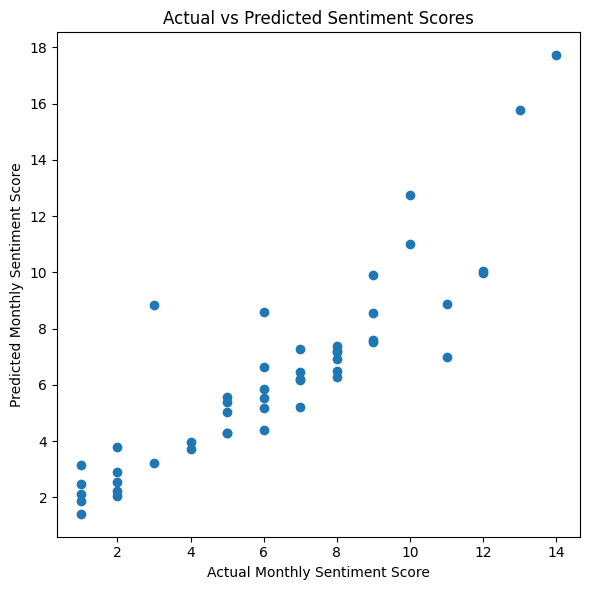

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Monthly Sentiment Score")
plt.ylabel("Predicted Monthly Sentiment Score")
plt.title("Actual vs Predicted Sentiment Scores")
plt.tight_layout()
plt.show()


## 10. Final Summary and Exports

In this section, we:
- Create summary tables needed for the report and README.
- Export key tables as CSV files.
- (Optionally) export plots into the `visualizations/` folder.


In [ ]:
import os

# Create folders if they don't exist
os.makedirs("outputs", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)


In [ ]:
# 1. Get unique months
all_months = sorted(monthly_scores["year_month"].unique())

ranking_rows = []

for month in all_months:
    top_pos, top_neg = get_monthly_rankings(monthly_scores, month)

    # Top positive
    for _, row in top_pos.iterrows():
        ranking_rows.append({
            "year_month": month,
            "employee": row["employee"],
            "monthly_sentiment_score": row["monthly_sentiment_score"],
            "rank_type": "Top Positive"
        })

    # Top negative
    for _, row in top_neg.iterrows():
        ranking_rows.append({
            "year_month": month,
            "employee": row["employee"],
            "monthly_sentiment_score": row["monthly_sentiment_score"],
            "rank_type": "Top Negative"
        })

rankings_df = pd.DataFrame(ranking_rows)

# Show a preview
rankings_df.head()


,year_month,employee,monthly_sentiment_score,rank_type
0,2010-01,kayne.coulter@enron.com,14,Top Positive
1,2010-01,eric.bass@enron.com,9,Top Positive
2,2010-01,lydia.delgado@enron.com,9,Top Positive
3,2010-01,bobette.riner@ipgdirect.com,1,Top Negative
4,2010-01,rhonda.denton@enron.com,1,Top Negative


In [ ]:
rankings_df.to_csv("outputs/employee_rankings_per_month.csv", index=False)
print("Saved: outputs/employee_rankings_per_month.csv")


Saved: outputs/employee_rankings_per_month.csv


In [ ]:
# Filter rows where the 30-day negative count crosses the threshold
flight_risk_df = (
    data[data["neg_30d_count"] >= 4]
    .copy()
)

# Optional: Keep only important columns
flight_risk_df = flight_risk_df[[
    "employee", "date", "sentiment_label", "neg_30d_count", "Subject", "body"
]].sort_values(["employee", "date"])

flight_risk_df.head()


,employee,date,sentiment_label,neg_30d_count,Subject,body
759,eric.bass@enron.com,2011-05-17,Negative,4.0,pc problems,"Hey don,\n\nI stopped by and missed you. Writ..."
760,eric.bass@enron.com,2011-05-17,Negative,4.0,pc problems,"Hey don,\n\nI stopped by and missed you. Writ..."
761,eric.bass@enron.com,2011-05-17,Positive,4.0,Caledonia unavailable,Please be advised that the Caledonia facility ...
762,eric.bass@enron.com,2011-05-17,Positive,4.0,Caledonia unavailable,Please be advised that the Caledonia facility ...
763,eric.bass@enron.com,2011-05-18,Positive,4.0,RAC risk reporting,"Currently, members of Ted Murphy's group have ..."


In [ ]:
flight_risk_df.to_csv("outputs/flight_risk_employees_details.csv", index=False)
print("Saved: outputs/flight_risk_employees_details.csv")

# Also a simple unique list for README
flight_risk_unique = sorted(flight_risk_df["employee"].unique())
print("Flight risk employees:", flight_risk_unique)


Saved: outputs/flight_risk_employees_details.csv
Flight risk employees: ['eric.bass@enron.com', 'johnny.palmer@enron.com', 'patti.thompson@enron.com', 'sally.beck@enron.com']


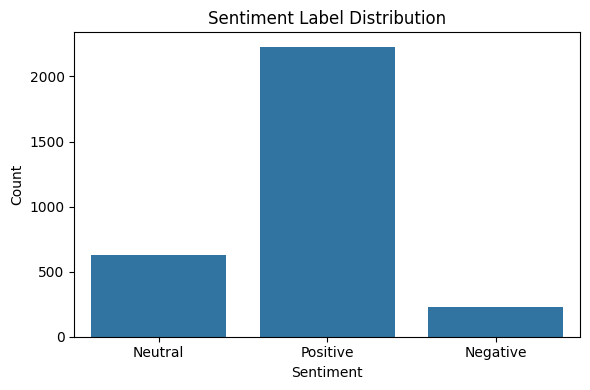

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment_label", data=data)
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()

# Save before show
plt.savefig("visualizations/sentiment_label_distribution.png", dpi=300)
plt.show()


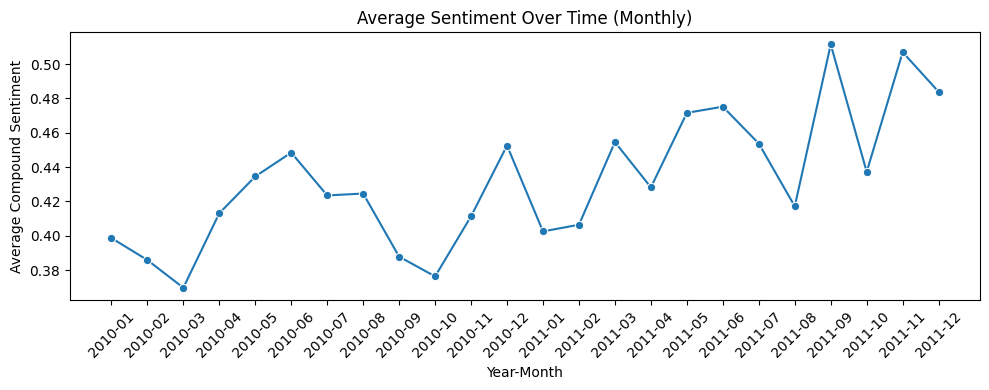

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(x="year_month", y="sentiment_compound", data=monthly_sentiment, marker="o")
plt.xticks(rotation=45)
plt.title("Average Sentiment Over Time (Monthly)")
plt.xlabel("Year-Month")
plt.ylabel("Average Compound Sentiment")
plt.tight_layout()

plt.savefig("visualizations/monthly_sentiment_trend.png", dpi=300)
plt.show()


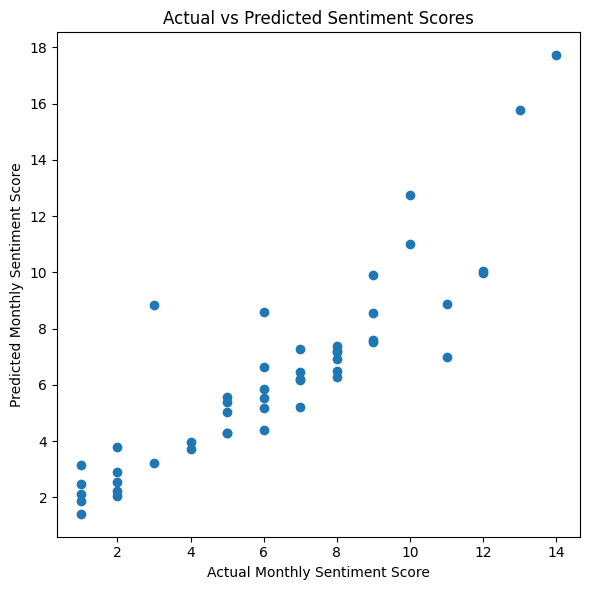

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Monthly Sentiment Score")
plt.ylabel("Predicted Monthly Sentiment Score")
plt.title("Actual vs Predicted Sentiment Scores")
plt.tight_layout()

plt.savefig("visualizations/regression_actual_vs_predicted.png", dpi=300)
plt.show()
